## TODO
* `gb_accession` and `gisaid_accession` are not found for new sequences, how do we concat to `metadata.csv` without them?
* metadata format for NCBI
* support tools for manual sanity checks

In [1]:
from bjorn import *
from bjorn_support import *
import gffutils

In [2]:
df = pd.read_csv('json_input.csv').sample(2)
df.to_csv('json_input.csv', index=False)

In [3]:
df.sample(100, replace=True).shape

(100, 46)

## Sequence Release

In [4]:
# df = pd.read_csv("/home/al/analysis/2020-12-01_release_2/metadata.csv")
# df.tail()

In [5]:
!cat run.sh

#!/bin/bash

python3 bjorn.py --not-dry-run --out-dir /home/al/analysis/bjorn_test --sample-sheet /home/al/data/COVID_sequencing_summary-GISAID.csv --cpus 8 --analysis-folder /home/gk/analysis/ --output-metadata /home/al/code/HCoV-19-Genomics/metadata.csv


In [6]:
# path to reference sequence (used later for MSA and tree construction)
ref_path = Path('/home/gk/code/hCoV19/db/NC045512.fasta')
# whether or not to include bam files in the release
include_bams = False
# path to reference sequence (used later for MSA and tree construction)
# this is the directory where results get saved
out_dir = Path('/home/al/analysis/bjorn_test')
# number of cores to use
num_cpus = 4
# file path to samples sheet (make sure it is the most recent)
sample_sheet_fpath = Path('/home/al/data/COVID_sequencing_summary-GISAID.csv')
# path to analysis results
analysis_fpath = Path('/home/gk/analysis/')
# file path to metadata of samples that have already been released
released_samples_fpath = Path('/home/al/code/HCoV-19-Genomics/metadata.csv')
# Whether run is dry
dry_run = True
# COLUMNS TO INCLUDE IN METADATA
git_meta_cols = ["ID", "collection_date", "location", 
                 "percent_coverage_cds", "avg_depth", 
                 "authors", "originating_lab"]
gisaid_meta_cols = ['Submitter',
                   'FASTA filename', 'Virus name', 'Type', 'Passage details/history',
                   'Collection date', 'location', 'Additional location information',
                   'Host', 'Additional host information', 'Gender', 'Patient age',
                   'Patient status', 'Specimen source', 'Outbreak', 'Last vaccinated',
                   'Treatment', 'Sequencing technology', 'Assembly method', 'Coverage',
                   'originating_lab', 'Address', 'Sample ID given by the sample provider',
                   'Submitting lab', 'Address.1',
                   'Sample ID given by the submitting laboratory', 'authors', 'avg_depth']

In [7]:



# # Test
# out_dir = "/home/gk/southpark/2020-11-21_release"
# sample_sheet_fpath = "/home/gk/code/hCoV19/release_summary_csv/2020-11-20_seq_summary.csv"
# analysis_fpath = "/home/gk/analysis/"
# released_samples_fpath = "/home/gk/analysis/hcov-19-genomics/metadata.csv"
# dry_run = True

print(f"""
Dry run: {dry_run}.
Include BAMS: {include_bams}.
Reading release summary file from {sample_sheet_fpath}.
Reading repository metadata from {released_samples_fpath}.
Searching analysis folder {analysis_fpath}.
"""
)

# Collecting Sequence Data


# grab all filepaths for bam data
bam_filepaths = glob.glob(f"{analysis_fpath}/**/merged_aligned_bams/illumina/*.bam")
bam_filepaths = [Path(fp) for fp in bam_filepaths]
# consolidate sample ID format
bam_ids = get_ids(bam_filepaths)
# Turn into dataframe
bam_data = list(zip(*[bam_ids, bam_filepaths]))
bam_df = pd.DataFrame(data=bam_data, columns=['sample_id', 'PATH'])
# grab all paths to consensus sequences
consensus_filepaths = glob.glob(f"{analysis_fpath}/**/consensus_sequences/illumina/*.fa")
consensus_filepaths = [Path(fp) for fp in consensus_filepaths]
# consolidate sample ID format
consensus_ids = get_ids(consensus_filepaths)
# Turn into dataframe
consensus_data = list(zip(*[consensus_ids, consensus_filepaths]))
consensus_df = pd.DataFrame(data=consensus_data, columns=['sample_id', 'PATH'])
# clean up cns and bam (remove duplicate IDs)
bam_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
consensus_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
# include only SEARCH samples
consensus_df = consensus_df[(consensus_df['sample_id'].str.contains('SEARCH'))]
# merge consensus and bam filepaths for each sample ID
analysis_df = pd.merge(consensus_df, bam_df, on='sample_id', how='left')
# load sample sheet data (GISAID) - make sure to download most recent one
seqsum = pd.read_csv(sample_sheet_fpath)
# clean up
seqsum = seqsum[(~seqsum['SEARCH SampleID'].isna()) & (seqsum['SEARCH SampleID']!='#REF!')]
# consolidate sample ID format
seqsum.loc[:, 'sample_id'] = seqsum['SEARCH SampleID'].apply(process_id)
seqsum.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
seqsum = seqsum[seqsum['New sequences ready for release'] == 'Yes']
num_seqs_to_release = seqsum['sample_id'].unique().shape[0]
# JOIN summary sheet with analysis meta data
sequence_results = pd.merge(seqsum, analysis_df, on='sample_id', how='inner')
# compute number of samples with missing consensus and/or bam files
num_seqs_found = sequence_results['sample_id'].unique().shape[0]
num_samples_missing_cons = num_seqs_to_release - num_seqs_found
num_samples_missing_bams = 'NA'
if include_bams:
    # exclude any samples that do not have BAM data
    num_samples_missing_bams = sequence_results[sequence_results['PATH_y'].isna()].shape[0]
    sequence_results = sequence_results[~sequence_results['PATH_y'].isna()]
# samples missing consensus or BAM sequence files
# ## Make sure to remove any samples that have already been uploaded to github (just an extra safety step)
# load metadata.csv from github repo, then clean up
meta_df = pd.read_csv(released_samples_fpath)
meta_df = meta_df[meta_df['ID'].str.contains('SEARCH')]
# consolidate sample ID format
meta_df.loc[:, 'sample_id'] = meta_df['ID'].apply(process_id)
# get IDs of samples that have already been released
released_seqs = meta_df['sample_id'].unique()
# filter out released samples from all the samples we got
final_result = sequence_results.copy()
# final_result = sequence_results[~sequence_results['sample_id'].isin(released_seqs)]
print(f"Preparing {final_result.shape[0]} samples for release")
# Transfer files
if not dry_run:
    transfer_files(final_result, out_dir, include_bams=include_bams, ncpus=num_cpus)
# ## Getting coverage information
cov_filepaths = glob.glob(f"{analysis_fpath}/**/trimmed_bams/illumina/reports/*.tsv")
cov_filepaths = [Path(fp) for fp in cov_filepaths]
# read coverage data and clean it up
cov_df = pd.concat((pd.read_csv(f, sep='\t').assign(path=f) for f in cov_filepaths))
cov_df.loc[:,'sample_id'] = cov_df['SAMPLE'].apply(process_coverage_sample_ids)
cov_df.loc[:,'date'] = cov_df['path'].apply(lambda x: ''.join(x.split('/')[4].split('.')[:3]))
cov_df = (cov_df.sort_values('date')
                .drop_duplicates(subset=['sample_id'], keep='last'))


Dry run: True.
Include BAMS: False.
Reading release summary file from /home/al/data/COVID_sequencing_summary-GISAID.csv.
Reading repository metadata from /home/al/code/HCoV-19-Genomics/metadata.csv.
Searching analysis folder /home/gk/analysis/.

Preparing 366 samples for release


In [8]:
# ans.columns

In [9]:
# JOIN results with coverage info
ans = (
    pd.merge(final_result, cov_df, on='sample_id', how='left')
    .assign(
        collection_date = lambda x: pd.to_datetime(x["Collection date"]).dt.strftime("%Y-%m-%d")
    )
    .rename(columns={
        "SEARCH SampleID": "ID",
        "Location": "location",
        "COVERAGE": "percent_coverage_cds",
        "AVG_DEPTH": "avg_depth",
        "Authors": "authors",
        "Originating lab": "originating_lab"
    })
)
num_samples_missing_coverage = ans[ans['percent_coverage_cds'].isna()].shape[0]

def create_github_meta(new_meta_df: pd.DataFrame, old_meta_filepath: str, meta_cols: list):
    """Generate Github metadata with updated information about newly released samples"""
    old_metadata = pd.read_csv(old_meta_filepath)
    new_metadata = pd.concat([old_metadata, new_meta_df.loc[:, meta_cols]])
    new_metadata.to_csv(out_dir/'metadata.csv', index=False)
    return f"Github metadata saved in {out_dir/'metadata.csv'}"

def create_gisaid_meta(new_meta_df: pd.DataFrame, meta_cols: list):
    """Generate GISAID metadata for newly released samples"""
    new_meta_df[meta_cols].to_csv(out_dir/'gisaid_metadata.csv', index=False)
    return f"GISAID metadata saved in {out_dir/'gisaid_metadata.csv'}"

create_github_meta(ans, released_samples_fpath, git_meta_cols)
create_gisaid_meta(ans, gisaid_meta_cols) 
low_coverage_samples = ans[ans["percent_coverage_cds"] < 90]
# Data logging
with open("{}/data_release.log".format(out_dir), 'w') as f:
    f.write(f'{num_samples_missing_coverage} samples are missing coverage information\n')
    f.write(f'{low_coverage_samples.shape[0]} samples were found to have coverage below 90%\n')
    f.write(f'{num_samples_missing_cons} samples were ignored because they were missing consensus sequence files\n')
    f.write(f'{num_samples_missing_bams} samples were ignored because they were missing BAM sequence files\n')
print(f"Transfer Complete. All results saved in {out_dir}")

Transfer Complete. All results saved in /home/al/analysis/bjorn_test


In [10]:
num_samples_missing_coverage

243

In [11]:
ans.columns

Index(['Sample ID', 'ID', 'Ready for release?',
       'New sequences ready for release', 'Released?', 'Submitter',
       'FASTA filename', 'Virus name', 'Type', 'Passage details/history',
       'Collection date', 'location', 'Additional location information',
       'Host', 'Additional host information', 'Gender', 'Patient age',
       'Patient status', 'Specimen source', 'Outbreak', 'Last vaccinated',
       'Treatment', 'Sequencing technology', 'Assembly method', 'Coverage',
       'originating_lab', 'Address', 'Sample ID given by the sample provider',
       'Submitting lab', 'Address.1',
       'Sample ID given by the submitting laboratory', 'authors', 'Comment',
       'Comment Icon', 'sample_id', 'PATH_x', 'PATH_y', 'SAMPLE',
       'percent_coverage_cds', 'avg_depth', 'MIN', 'MAX', 'ZERO_DEPTH', 'path',
       'date', 'collection_date'],
      dtype='object')

## Genbank

In [12]:
cons_seqs = Path(out_dir/'fa')

In [13]:
msa_dir = out_dir/'msa'
if not Path.isdir(msa_dir):
    Path.mkdir(msa_dir);

In [14]:
cons_seqs = Path(out_dir/'fa')
copy(ref_path, cons_seqs)

Path('/home/al/analysis/bjorn_test/fa/NC045512.fasta')

In [15]:
out_dir.basename()

Path('bjorn_test')

In [16]:
# concat_fasta(out_dir, msa_dir/out_dir.basename())

In [17]:
!ls {msa_dir}

bjorn_test_aligned.fa  bjorn_test.fa


In [18]:
# cns_seqs = SeqIO.parse(msa_dir/out_dir.basename()+'.fa', 'fasta')
# cns_seqs = list(cns_seqs)

In [19]:
def create_genbank_meta(df: pd.DataFrame, meta_cols: list) -> pd.DataFrame:
    genbank_meta = df[meta_cols].copy()
    genbank_meta['country'] = genbank_meta['location'].apply(lambda x: x.split('/')[0])
    genbank_meta['isolate'] = genbank_meta['Virus name'].str.replace('hCoV-19', 'SARS-CoV-2/human')
    genbank_meta['host'] = genbank_meta['Host'].str.replace('Human', 'Homo Sapiens')
    genbank_meta.rename(columns={'Virus name': 'Sequence_ID', 'collection_date': 'collection-date',
                                 'Specimen source': 'isolation-source'}, inplace=True)
    genbank_meta.loc[genbank_meta['country']=='MEX', 'country'] = 'Mexico'
    return genbank_meta[['Sequence_ID', 'isolate', 'country', 
                         'collection-date', 'host', 'isolation-source']]

In [20]:
def assemble_genbank_release(cns_seqs: list, df: pd.DataFrame, meta_cols: list):
    # create directory for genbank release
    genbank_dir = out_dir/'genbank'
    if not Path.isdir(genbank_dir):
        Path.mkdir(genbank_dir);
    authors = {}
    # group samples by author
    for ctr, (n, grp) in enumerate(df.groupby('authors')):
        authors[ctr+1] = n
        # generate sample metadata
        genbank_meta = create_genbank_meta(grp, meta_cols)
        genbank_meta.to_csv(genbank_dir/f'genbank_metadata_{ctr+1}.tsv', sep='\t', index=False)
        # fetch consensus sequences of those samples
        recs = [i for i in cns_seqs if i.name in genbank_meta['Sequence_ID'].tolist()]
        SeqIO.write(recs, genbank_dir/f'genbank_release_{ctr+1}.fa', 'fasta')
    # write mapping of index to author for later reference
    (pd.DataFrame.from_dict(authors, orient='index')
       .rename(columns={0: 'authors'})
       .to_csv(genbank_dir/'authors.tsv', sep='\t'))
    return f"Genbank data release saved in {genbank_dir}"

In [21]:
# genbank_meta_cols = ['Sample ID', 'ID', 'Virus name', 'location', 
#                         'Specimen source', 'collection_date', 'Host']
# assemble_genbank_release(cns_seqs, ans, genbank_meta_cols)

## SRA

In [22]:
# sra_dir = out_dir/'sra'
# if not Path.isdir(sra_dir):
#     Path.mkdir(sra_dir);
# input(f"Have you received the BioSample.txt files and placed them inside {sra_dir}? \n \
# Press Enter to continue...")

In [23]:
def create_sra_meta(df: pd.DataFrame, sra_dir: Path):
    biosample_paths = glob.glob(f"{sra_dir}/*.txt")
    biosample_df = pd.concat((pd.read_csv(f, sep='\t') for f in biosample_paths))
    biosample_df["sample_id"] = biosample_df["Sample Name"].apply(lambda x: "".join(x.split("-")[:2]))
    bam_files = ans.loc[~ans['PATH_y'].isna()][['sample_id', 'PATH_y']].rename(columns={'PATH_y': 'file_name'})
    sra_merged = pd.merge(biosample_df, bam_files, on="sample_id")
    sra_merged[["Accession", "Sample Name", "file_name"]].to_csv(sra_dir/"sra_metadata.csv", index=False)
    return f"SRA metadata saved in {sra_dir/'sra_metadata.csv'}"

In [24]:
# TEST behavior
# cat_cmd = f"cat {out_dir}/fa/*.fa > {msa_dir/out_dir.basename()}.fa"
# subprocess.check_call(cat_cmd, shell=True)

## INDELS

In [25]:
# msa_fp = align_fasta(msa_dir/out_dir.basename())

In [26]:
msa_fp = msa_dir/'bjorn_test_aligned.fa'

In [27]:
from onion_trees import *

In [28]:
patient_zero = 'NC_045512.2'

In [29]:
# read MSA file
cns_seqs = AlignIO.read(msa_fp, 'fasta')
type(cns_seqs)

Bio.Align.MultipleSeqAlignment

In [30]:
seqs = get_seqs(cns_seqs)
seqsdf = (pd.DataFrame(index=seqs.keys(), data=seqs.values(), columns=['sequence'])
            .reset_index().rename(columns={'index': 'idx'}))

In [31]:
seqsdf.loc[seqsdf['idx'].str.contains('4650'), 'sequence'].values[0][25890:25914]

'atccgaacaggccacaaatgagtt'

In [32]:
seqsdf.loc[seqsdf['idx'].str.contains('NC'), 'sequence'].values[0][25890:25914]

'atccg--------------gagtt'

In [33]:
inserts = identify_insertions(msa_fp, patient_zero)
inserts

,relative_coords,ins_len,samples,num_samples,type,absolute_coords,prev_5nts,next_5nts,gene
1,25895:25908,14,[hCoV-19/USA/SEARCH-4650-SAN/2020],1,insertion,26160:26173,atccg,gagtt,ORF3a
0,10811:10813,3,"[hCoV-19/USA/SEARCH-4288-SAN/2020, hCoV-19/USA...",2,insertion,11076:11078,tgttc,ttttt,ORF1ab


In [34]:
seqsdf.loc[seqsdf['idx'].str.contains('4351'), 'sequence'].values[0][1334:1347]

'tctta---acaac'

In [35]:
dels = identify_deletions(msa_fp, patient_zero)
dels

,relative_coords,del_len,samples,num_samples,type,absolute_coords,prev_5nts,next_5nts,gene
0,1339:1341,3,[hCoV-19/USA/SEARCH-4351-SAN/2020],1,deletion,1604:1606,tctta,acaac,ORF1ab
2,21716:21727,12,[hCoV-19/USA/SEARCH-4199-SAN/2020],1,deletion,21981:21992,ccatt,ttacc,S
3,249:254,6,[hCoV-19/USA/SEARCH-4206-SAN/2020],1,deletion,514:519,gtcat,gttga,ORF1ab
5,251:254,4,[hCoV-19/USA/SEARCH-4449-SAN/2020],1,deletion,516:519,catgt,gttga,ORF1ab
7,25894:25901,8,[hCoV-19/USA/SEARCH-4264-SAN/2020],1,deletion,26159:26166,gttgt,taatg,ORF3a
11,27818:27844,27,[hCoV-19/USA/SEARCH-4298-SAN/2020],1,deletion,28083:28109,ggatg,acatc,ORF8
12,27824:27829,6,[hCoV-19/USA/SEARCH-4583-SAN/2020],1,deletion,28089:28094,ggctg,aatca,ORF8
13,28615:28632,18,[hCoV-19/USA/SEARCH-4145-SAN/2020],1,deletion,28880:28897,cagta,gaatg,N
6,25892:25895,4,"[hCoV-19/USA/SEARCH-4355-SAN/2020, hCoV-19/USA...",2,deletion,26157:26160,gagtt,atcca,ORF3a
8,27421:27444,24,"[hCoV-19/USA/SEARCH-4225-SAN/2020, hCoV-19/USA...",2,deletion,27686:27709,tactc,aatag,ORF7a


In [36]:
ref_seq = get_seq(cns_seqs, patient_zero)[265:29674]
insert_positions = identify_insertion_positions(ref_seq)
seqs = get_seqs(cns_seqs)
seqsdf = (pd.DataFrame(index=seqs.keys(), data=seqs.values(), columns=['sequence'])
            .reset_index().rename(columns={'index': 'idx'}))
# seqsdf

In [25]:
# seqsdf.iloc[2]['sequence'][10811:]

In [26]:
# insert_positions

In [27]:
# min_ins_len = 1
# def find_insertions(x):
#     ins_positions = [m for m in insert_positions if x[m]!='-' and x[m]!='n']
#     insertions = [list(insert) for insert in mit.consecutive_groups(ins_positions)]
#     return insertions
# seqsdf['ins_positions'] = seqsdf['sequence'].apply(find_insertions)
# ins_seqs = seqsdf.loc[seqsdf['ins_positions'].str.len() > 0]
# ins_seqs = ins_seqs.explode('ins_positions')
# ins_seqs['ins_len'] = ins_seqs['ins_positions'].apply(len)
# # only consider deletions longer than 2nts
# ins_seqs = ins_seqs[ins_seqs['ins_len'] > min_ins_len]
# # fetch coordinates of each deletion
# ins_seqs['ins_coords'] = ins_seqs['ins_positions'].apply(get_coords)
# # group sample by the deletion they share
# ins_seqs = (ins_seqs.groupby(['ins_coords', 'ins_len'])
#                     .agg(samples=('idx', 'unique'),       # list of sample IDs with the deletion
#                          num_samples=('idx', 'nunique'))  # num of samples with the deletion
#                     .reset_index()
#                     .sort_values('num_samples'))

In [28]:
ins_seqs

,ins_coords,ins_len,samples,num_samples
1,25895:25908,14,[hCoV-19/USA/SEARCH-4650-SAN/2020],1
0,10811:10813,3,"[hCoV-19/USA/SEARCH-4288-SAN/2020, hCoV-19/USA...",2


In [22]:
ref_seq = get_seq(cns_seqs, patient_zero)

In [67]:
for rec in cns_seqs:
    if rec.id=='hCoV-19/USA/SEARCH-4206-SAN/2020':
        seq = rec.seq

In [69]:
seq[509:530]

'gtcat------gttgagctgg'

In [23]:
seqs, ref_seq = process_cns_seqs(cns_seqs, patient_zero)

In [71]:
# deletions = identify_deletions(msa_fp, patient_zero, min_del_len=1)
# deletions['del_coords'] = deletions['del_coords'].apply(adjust_coords)
# deletions['prev_5nts'] = deletions['del_coords'].apply(lambda x: ref_seq[int(x.split(':')[0])-5:int(x.split(':')[0])])
# deletions['next_5nts'] = deletions['del_coords'].apply(lambda x: ref_seq[int(x.split(':')[1])+1:int(x.split(':')[1])+6])
# deletions['gene'] = deletions['del_coords'].apply(lambda x: int(x.split(':')[0])).apply(map_gene_to_pos)
# deletions.to_csv(out_dir/'deletions.csv', index=False)

In [73]:
# pd.read_csv(out_dir/'deletions.csv')

In [74]:
!ls {msa_dir}

bjorn_test_aligned.fa  bjorn_test.fa


In [75]:
# TEST behavior
# msa_cmd = f"mafft --auto --thread {num_cpus} {msa_dir/out_dir.basename()}.fa > {msa_dir/out_dir.basename()}_aligned.fa"
# subprocess.check_call(msa_cmd, shell=True)

In [77]:
# ans.head()

In [78]:
# ans.to_csv('json_input.csv', index=False)

## JSON metadata for CViSB portal

In [79]:
# datadownload.json
{"includedInDataset": "sarscov2-virus-seq", "identifier": "SEARCH-0289-NBG.fa", 
 "name": "SEARCH-0289-NBG.fa", 
 "contentUrl": "https://console.cloud.google.com/storage/browser/_details/andersen-lab_hcov-19-genomics/consensus_sequences/SEARCH-0289-NBG.fa", 
 "additionalType": "raw data", "variableMeasured": ["SARS-CoV-2 virus sequence"], 
 "measurementTechnique": ["Nucleic Acid Sequencing"], 
 "dateModified": "2020-11-16", "experimentIDs": ["SEARCH-0289-NBG-sarscov2"]}

{'includedInDataset': 'sarscov2-virus-seq',
 'identifier': 'SEARCH-0289-NBG.fa',
 'name': 'SEARCH-0289-NBG.fa',
 'contentUrl': 'https://console.cloud.google.com/storage/browser/_details/andersen-lab_hcov-19-genomics/consensus_sequences/SEARCH-0289-NBG.fa',
 'additionalType': 'raw data',
 'variableMeasured': ['SARS-CoV-2 virus sequence'],
 'measurementTechnique': ['Nucleic Acid Sequencing'],
 'dateModified': '2020-11-16',
 'experimentIDs': ['SEARCH-0289-NBG-sarscov2']}

In [80]:
# patient.json
{"patientID": "SEARCH-0289-NBG", 
 "dateModified": "2020-11-16", 
 "cohort": "COVID-19", 
 "outcome": "unknown", 
 "alternateIdentifier": ["SEARCH-0289-NBG"], 
 "infectionYear": 2020, 
 "publisher": {"@type": "Organization", 
               "identifier": "CViSB", 
               "url": "https://cvisb.org/", 
               "name": "Center for Viral Systems Biology", 
               "contactPoint": {"@type": "ContactPoint", "contactType": "technical support", 
                                "url": "https://cvisb.org/", "email": "info@cvisb.org"}}, 
 "citation": [{"name": "Allison Smither, Gilberto Sabino-Santos, Patricia Snarski, Lilia Melnik, Antoinette Bell, Kaylynn Genemaras, Arnaud Drouin, Dahlene Fusco, Robert Garry with SEARCH Alliance San Diego", "@type": "Organization"}],
 "updatedBy": "Julia Mullen", 
 "country": {"@type": "Country", "name": "United States", "administrativeUnit": 0, "administrativeType": "country", "identifier": "US", "url": "https://www.iso.org/obp/ui/#iso:code:3166:US"}, "presentationDate": "2020-03-31", 
 "presentationWeek": {"gt": "2020-03-30", "lt": "2020-04-06"}},

({'patientID': 'SEARCH-0289-NBG',
  'dateModified': '2020-11-16',
  'cohort': 'COVID-19',
  'outcome': 'unknown',
  'alternateIdentifier': ['SEARCH-0289-NBG'],
  'infectionYear': 2020,
  'publisher': {'@type': 'Organization',
   'identifier': 'CViSB',
   'url': 'https://cvisb.org/',
   'name': 'Center for Viral Systems Biology',
   'contactPoint': {'@type': 'ContactPoint',
    'contactType': 'technical support',
    'url': 'https://cvisb.org/',
    'email': 'info@cvisb.org'}},
  'citation': [{'name': 'Allison Smither, Gilberto Sabino-Santos, Patricia Snarski, Lilia Melnik, Antoinette Bell, Kaylynn Genemaras, Arnaud Drouin, Dahlene Fusco, Robert Garry with SEARCH Alliance San Diego',
    '@type': 'Organization'}],
  'updatedBy': 'Julia Mullen',
  'country': {'@type': 'Country',
   'name': 'United States',
   'administrativeUnit': 0,
   'administrativeType': 'country',
   'identifier': 'US',
   'url': 'https://www.iso.org/obp/ui/#iso:code:3166:US'},
  'presentationDate': '2020-03-31',
  

In [82]:
# # experiment.json
# {"experimentID": "MG0987-sarscov2", 
#  "privatePatientID": "MG0987", 
#  "variableMeasured": "SARS-CoV-2 virus sequence", 
#  "measurementTechnique": "Nucleic Acid Sequencing", 
#  "includedInDataset": "sarscov2-virus-seq", 
#  "dateModified": "2020-11-16", 
#  "citation": [{"name": "SEARCH Alliance San Diego", 
#                "@type": "Organization"}], 
#  "data": [{"@type": "VirusSeqData", "virus": "SARS-CoV-2", 
#            "virusSegment": null, "DNAsequence": "NNN"}]}

In [83]:
def to_json_entry(x):
    """Return experiment metadata in JSON format compatible with CViSB Data Portal"""
    patient_id = x['ID']
    date = x['collection_date']
    authors = x['authors']
    return {"experimentID": f"{patient_id}-sarscov2", "privatePatientID": patient_id, 
           "variableMeasured": "SARS-CoV-2 virus sequence", 
           "measurementTechnique": "Nucleic Acid Sequencing", 
           "includedInDataset": "sarscov2-virus-seq", 
           "dateModified": date, 
           "citation": [{"name": authors, 
                         "@type": "Organization"}], "data": []}

# ans.apply(to_json_entry, axis=1).tolist()

## Trees

## iSNV Analysis

In [2]:
cols = ['sample', 'GFF_FEATURE', 'POS', 'REF', 'ALT', 'ALT_FREQ']

In [5]:
sample_ids = [4531, 4690, 4691]
v_fps = get_variant_filepaths(sample_ids)
v_df = get_variant_data(v_fps)[cols]
v_df.drop_duplicates(subset=['sample', 'POS', 'ALT'], inplace=True)

In [6]:
v_fps

{4531: '/home/gk/analysis/2020.11.25.hCoV19/variants/illumina/SEARCH-4531_L001_L002_L003_L004.tsv',
 4690: '/home/gk/analysis/2020.11.25.hCoV19/variants/illumina/SEARCH-4690_L001_L002_L003_L004.tsv',
 4691: '/home/gk/analysis/2020.11.25.hCoV19/variants/illumina/SEARCH-4691_L001_L002_L003_L004.tsv'}

In [7]:
v_df[v_df['POS']==12369]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
9,4531,cds-YP_009724389.1,12369,C,T,1.000000
27,4690,cds-YP_009724389.1,12369,C,T,0.976622


In [8]:
v_df.loc[(v_df['REF']=='C')&(v_df['ALT']=='T')&(v_df['POS'] > 12300)&(v_df['POS'] < 12400)][['sample', 'POS', 'REF', 'ALT', 'ALT_FREQ']]

,sample,POS,REF,ALT,ALT_FREQ
9,4531,12369,C,T,1.000000
27,4690,12369,C,T,0.976622


In [7]:
ans = v_df.loc[(v_df.duplicated(subset=['POS'], keep=False))][['sample', 'POS', 'REF', 'ALT', 'ALT_FREQ']].sort_values('POS')


In [8]:
v_df['var'] = v_df['POS'].astype(str) + ':' + v_df['ALT']
v_df[v_df['ALT_FREQ'] < 0.5].groupby('sample').agg(num_minor_vars=('var', 'nunique'))

,num_minor_vars
sample,
4531,6
4690,33
4691,14


In [9]:
v_df.loc[(v_df['sample']==4531)&(v_df['ALT_FREQ']<0.5)][cols]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
5,4531,NaN,1601,C,-TTA,0.045389
8,4531,NaN,6696,C,+T,0.041880
11,4531,cds-YP_009724389.1,13940,A,G,0.057012
19,4531,cds-YP_009724390.1,22165,T,C,0.030303
22,4531,NaN,22583,G,+T,0.092683
27,4531,cds-YP_009724390.1,24072,A,G,0.039066


In [10]:
v_df.loc[v_df['POS']==29348][cols]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
58,4690,cds-YP_009724397.2,29348,G,T,0.522132


In [11]:
v_df[(v_df['REF']=='G')&(v_df['ALT']=='T')][cols]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
21,4531,cds-YP_009724390.1,22343,G,T,1.000000
28,4531,cds-YP_009724391.1,25563,G,T,1.000000
29,4531,cds-YP_009724397.2,28899,G,T,0.999853
15,4690,cds-YP_009724389.1,4806,G,T,0.047414
50,4690,cds-YP_009724391.1,25563,G,T,1.000000
58,4690,cds-YP_009724397.2,29348,G,T,0.522132
9,4691,cds-YP_009724389.1,7805,G,T,0.032258
22,4691,cds-YP_009724390.1,22775,G,T,0.032258
26,4691,cds-YP_009724391.1,25563,G,T,1.000000


In [12]:
ans.to_excel('common_variants.xlsx', index=False)

In [18]:
var_fps = glob.glob(f"/home/gk/analysis/**/variants/illumina/*.tsv")
var_df = (pd.concat((pd.read_csv(f, sep='\t') for f in var_fps)))
print(var_df.shape)
var_df.head()

(140796, 40)


,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,...,REF_RV_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,REF_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_RV_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_FREQ_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,TOTAL_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PVAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PASS_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,Unnamed: 29
0,NC_045512.2,241,C,T,1.0,0.0,72.0,3314.0,769.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NC_045512.2,1884,C,T,1541.0,1085.0,39.0,66.0,35.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC_045512.2,1884,C,T,1541.0,1085.0,39.0,66.0,35.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC_045512.2,2455,C,T,0.0,0.0,0.0,371.0,227.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_045512.2,2455,C,T,0.0,0.0,0.0,371.0,227.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
gff_filepath = '/home/al/data/hcov19/gff/NC_045512.2.gff3'
fn = gffutils.example_filename(gff_filepath)
db = gffutils.create_db(fn, dbfn='test.db', merge_strategy='merge', force=True)
all_gffs = var_df['GFF_FEATURE'].dropna().unique()
gff2gene = {}
for gff in all_gffs:
    if gff:
        gff2gene[gff] = db[gff]['gene'][0]
gff2gene

{'cds-YP_009724389.1': 'ORF1ab',
 'cds-YP_009725295.1': 'ORF1ab',
 'cds-YP_009724390.1': 'S',
 'cds-YP_009724396.1': 'ORF8',
 'cds-YP_009724397.2': 'N',
 'cds-YP_009724395.1': 'ORF7a',
 'cds-YP_009724391.1': 'ORF3a',
 'cds-YP_009724393.1': 'M',
 'cds-YP_009724394.1': 'ORF6',
 'cds-YP_009725255.1': 'ORF10',
 'cds-YP_009725318.1': 'ORF7b',
 'cds-YP_009724392.1': 'E'}

In [20]:
var_df['gene'] = var_df['GFF_FEATURE'].apply(lambda x: gff2gene.get(x, 'nan'))

In [84]:
# var_df.drop(columns=['GFF_FEATURE'], inplace=True)
# try:
#     var_df['gene'] = var_df['GFF_FEATURE'].apply(lambda x: gff2gene.get(x, 'nan'))
# except:
#     raise KeyError('GFF_FEATURE column not found in the input dataframe.')

In [85]:
# var_df.loc[var_df['gene']=='nan']

In [86]:
# var_df.loc[var_df['gene']=='nan', 'gene'] = var_df.loc[var_df['gene']=='nan', 'POS'].apply(map_gene_to_pos)
# var_df.loc[var_df['gene']=='nan']

In [16]:
def map_gene_to_pos(x):
    pos = x
    if pos >= 269 and pos <= 21555:
        return 'ORF1ab'
    elif pos >= 21564 and pos <= 25382:
        return 'S'
    elif pos >= 25410 and pos <= 26214:
        return 'ORF3a'
    elif pos >= 26247 and pos <= 26471:
        return 'E'
    elif pos >= 26523 and pos <= 27187:
        return 'M'
    elif pos >= 27203 and pos <= 27382:
        return 'ORF6'
    elif pos >= 27398 and pos <= 27754:
        return 'ORF7a'
    elif pos >= 27757 and pos <= 27887:
        return 'ORF7b'
    elif pos >= 27896 and pos <= 28257:
        return 'ORF8'
    elif pos >= 28289 and pos <= 29528:
        return 'N'
    elif pos >= 29564 and pos <= 29670:
        return 'ORF10'
    return 'nan'
# v_df = v_df.apply(map_gene_to_pos, axis=1)

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [76]:
colors = list(mcolors.TABLEAU_COLORS.keys())
len(colors)

10

In [77]:
colors = colors + ['black']

In [78]:
colors

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan',
 'black']

In [79]:
v_df['gene'].unique()

array(['nan', 'ORF1ab', 'S', 'ORF3a', 'N', 'M', 'ORF7b', 'E'],
      dtype=object)

In [80]:
genes = ['ORF1ab', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a',
         'ORF7b', 'ORF8', 'N', 'ORF10']

In [81]:
gene2color = {}
for i, g in enumerate(genes):
    gene2color[g] = colors[i]

In [82]:
v_df['color'] = v_df['gene'].apply(lambda x: gene2color.get(x, 'tab:white'))
v_df

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ,var,gene,color
0,4531,NaN,241,C,T,1.000000,241:T,nan,tab:white
1,4531,cds-YP_009724389.1,1059,C,T,1.000000,1059:T,ORF1ab,tab:blue
3,4531,cds-YP_009724389.1,1102,C,T,1.000000,1102:T,ORF1ab,tab:blue
5,4531,NaN,1601,C,-TTA,0.045389,1601:-TTA,ORF1ab,tab:blue
6,4531,cds-YP_009724389.1,3037,C,T,1.000000,3037:T,ORF1ab,tab:blue
...,...,...,...,...,...,...,...,...,...
25,4691,cds-YP_009724390.1,23403,A,G,0.999815,23403:G,S,tab:orange
26,4691,cds-YP_009724391.1,25563,G,T,1.000000,25563:T,ORF3a,tab:green
27,4691,cds-YP_009724392.1,26300,T,C,0.083333,26300:C,E,tab:red
28,4691,NaN,28969,C,-A,0.034876,28969:-A,N,tab:cyan


In [83]:
gene2color

{'ORF1ab': 'tab:blue',
 'S': 'tab:orange',
 'ORF3a': 'tab:green',
 'E': 'tab:red',
 'M': 'tab:purple',
 'ORF6': 'tab:brown',
 'ORF7a': 'tab:pink',
 'ORF7b': 'tab:gray',
 'ORF8': 'tab:olive',
 'N': 'tab:cyan',
 'ORF10': 'black'}

In [84]:
def get_color_legends(del2color: dict) -> list:
    legend_elements = [Line2D([0], [0], marker='o', color=x, label=y,
                       markerfacecolor=x, markersize=15) for y, x in del2color.items()]
    return legend_elements
legend = get_color_legends(gene2color)
legend

In [85]:
plt.rcParams["figure.figsize"] = (15,15)

In [89]:
s[['POS', 'ALT_FREQ']].values.tolist()

[[3545.0, 0.030302999999999997],
 [6696.0, 0.035313],
 [7735.0, 0.0740741],
 [7805.0, 0.0322581],
 [7930.0, 0.043478300000000004],
 [7953.0, 0.0625],
 [11074.0, 0.034832199999999994],
 [22000.0, 0.04],
 [22120.0, 0.04],
 [22775.0, 0.0322581],
 [22776.0, 0.0322581],
 [26300.0, 0.08333330000000001],
 [28969.0, 0.034876300000000006]]

In [93]:
import seaborn as sns
samples = v_df['sample'].unique()
for s_id in samples:
    s = v_df.loc[(v_df['sample']==s_id)&(v_df['ALT_FREQ']<0.5)&(v_df['gene']!='nan')]
    # I load the seaborn library only to benefit the nice looking feature
    plt.vlines(x=s['POS'], ymin=0, ymax=s['ALT_FREQ'], color=s['color'], alpha=0.4)
    plt.scatter(s['POS'], s['ALT_FREQ'], color=s['color'], s=50, alpha=1)
    for x in s[['POS', 'ALT_FREQ']].values.tolist():
        plt.text(x[0], x[1]+0.001, f"{int(x[0])}", ha='center')
    plt.legend(handles=legend, loc='upper right')
    plt.xlabel('POS')
    plt.ylabel('ALT_FREQ')
    plt.title(f'Minor Variants of Sample {s_id}')
    plt.savefig(f'{s_id}_minor_variants.png')
    plt.clf()

<Figure size 1080x1080 with 0 Axes>

In [97]:
v_df[v_df['ALT_FREQ']<0.5].sort_values('POS').to_excel('minor_variants.xlsx', index=False)

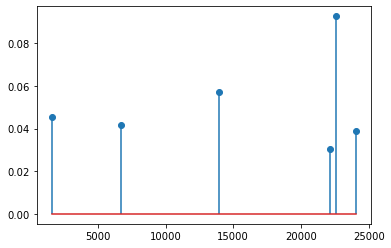

In [30]:
my_range=range(1,len(s.index)+1)
 
# Make the plot
plt.stem(s['POS'], s['ALT_FREQ'], label=s['gene'])
plt.show()
